In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from time import time
import os
from os.path import join, getsize, isfile, isdir, splitext
import pandas as pd

In [2]:
! pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_312
Branch HEAD
Compiled by user centos on 2021-05-24T04:27:48Z
Revision de351e30a90dd988b133b3d00fa6218bfcaba8b8
Url https://github.com/apache/spark
Type --help for more information.


In [3]:
data_path = '/media/daniel/Seagate Basic/spark_data/sensores/' # en esta carpeta deben encontrarse los 4 ficheros

In [4]:
spark = SparkSession.builder.master("local[*]")\
          .appName("practica 2 Ecosistema Spark parte 2")\
          .getOrCreate()

22/01/09 12:05:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
schema = StructType([StructField('index', IntegerType(), True),
                     StructField('arrival_time', LongType(), True),
                     StructField('creation_time', LongType(), True),
                     StructField('x', FloatType(), True),
                     StructField('y', FloatType(), True),
                     StructField('z', FloatType(), True),
                     StructField('user', StringType(), True),
                     StructField('model', StringType(), True),
                     StructField('device', StringType(), True),
                     StructField('gt', StringType(), True)])

df_phones_acc   = spark.read.csv(data_path+'Phones_accelerometer.csv', schema=schema)
df_phones_gyros = spark.read.csv(data_path+'Phones_gyroscope.csv', schema=schema)
df_watch_acc    = spark.read.csv(data_path+'Watch_accelerometer.csv', schema=schema)
df_watch_gyros  = spark.read.csv(data_path+'Watch_gyroscope.csv', schema=schema)

# 1. Creación de los ficheros parquet

In [6]:
def GetFolderSize(path):
    
    
    TotalSize = 0
    for item in os.walk(path):
        for file in item[2]:
            try:
                TotalSize = TotalSize + getsize(join(item[0], file))
            except:
                print("error with file:  " + join(item[0], file))
    return TotalSize

In [8]:
df_phones_acc.write.parquet(data_path+'Phones_accelerometer.parquet')
df_phones_gyros.write.parquet(data_path+'Phones_gyroscope.parquet')
df_watch_acc.write.parquet(data_path+'Watch_accelerometer.parquet')
df_watch_gyros.write.parquet(data_path+'Watch_gyroscope.parquet')

22/01/09 12:06:18 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
22/01/09 12:06:18 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
22/01/09 12:06:48 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
22/01/09 12:07:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
22/01/09 12:07:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
22/01/09 12:07:28 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
22/01/09 12:07:29 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014

In [9]:
for folder in ['Phones_accelerometer', 'Phones_gyroscope', 'Watch_accelerometer', 'Watch_gyroscope']:
    
    parquet_size = GetFolderSize(data_path+folder+'.parquet')*10e-10
    csv_size = getsize(data_path+folder+'.csv')*10e-10
    print(f'file: {folder} | csv size: {round(csv_size, 2)} GB | parquet size: {round(parquet_size, 3)} GB | compression rate: {round(100*(1-parquet_size/csv_size), 2)}%')

file: Phones_accelerometer | csv size: 1.29 GB | parquet size: 0.26 GB | compression rate: 79.88%
file: Phones_gyroscope | csv size: 1.38 GB | parquet size: 0.278 GB | compression rate: 79.88%
file: Watch_accelerometer | csv size: 0.33 GB | parquet size: 0.073 GB | compression rate: 77.69%
file: Watch_gyroscope | csv size: 0.31 GB | parquet size: 0.066 GB | compression rate: 78.61%


Se observa que el formato parquet ha reducido en un 80% (aprox.) el tamaño de los ficheros csv.

# 2. Tiempo de lectura y carga de un dataframe de spark desde distintos formatos

## 2.1 Creación de dataframes desde RDD

Se crean los RDDs y se separan las filas de los ficheros en columnas (split).

In [10]:
phones_acc = spark.sparkContext.textFile(data_path+'Phones_accelerometer.csv').map(lambda x: x.split(','))
phones_gyros = spark.sparkContext.textFile(data_path+'Phones_gyroscope.csv').map(lambda x: x.split(','))
watch_acc = spark.sparkContext.textFile(data_path+'Watch_accelerometer.csv').map(lambda x: x.split(','))
watch_gyros = spark.sparkContext.textFile(data_path+'Watch_gyroscope.csv').map(lambda x: x.split(','))

Se pasa a datafrane y se hace un recuento de observaciones para que genere de manera efectiva el dataframe y salga del modo lazy.

In [11]:
t0=time()

phones_acc_df = spark.createDataFrame(phones_acc)
phones_gyros_df = spark.createDataFrame(phones_acc)
watch_acc_df = spark.createDataFrame(phones_acc)
watch_gyros_df = spark.createDataFrame(phones_acc)

phones_acc_df.count(), phones_gyros_df.count(), watch_acc_df.count(), watch_gyros_df.count()

tf = time()

print(f'elapsed time: {tf-t0}')

total_rdd = tf-t0

elapsed time: 212.93428468704224


## 2.2 Creación de dataframes desde formato parquet 

Se leen los ficheros con la función específica.

In [12]:
t0=time()

phones_acc_df = spark.read.load(data_path+'Phones_accelerometer.parquet', schema=schema)
phones_gyros_df = spark.read.load(data_path+'Phones_gyroscope.parquet', schema=schema)
watch_acc_df = spark.read.load(data_path+'Watch_accelerometer.parquet', schema=schema)
watch_gyros_df = spark.read.load(data_path+'Watch_gyroscope.parquet', schema=schema)

phones_acc_df.count(), phones_gyros_df.count(), watch_acc_df.count(), watch_gyros_df.count()

tf = time()

print(f'elapsed time: {tf-t0}')

total_parquet = tf-t0

elapsed time: 2.484624147415161


## 2.3 Creación de dataframes desde formato csv

Se leen los ficheros con la función específica.

In [14]:
t0=time()

phones_acc_df = spark.read.csv(data_path+'Phones_accelerometer.csv', schema=schema)
phones_gyros_df = spark.read.csv(data_path+'Phones_gyroscope.csv', schema=schema)
watch_acc_df = spark.read.csv(data_path+'Watch_accelerometer.csv', schema=schema)
watch_gyros_df = spark.read.csv(data_path+'Watch_gyroscope.csv', schema=schema)

phones_acc_df.count(), phones_gyros_df.count(), watch_acc_df.count(), watch_gyros_df.count()

tf = time()

print(f'elapsed time: {tf-t0}')

total_csv = tf-t0

elapsed time: 25.451250314712524


## 3. Conclusión

Se aprecia que aunque se esté realizando la misma operación en los tres casos (lectura y recuento de filas), se obtienen distintos tiempos. Se ve que la manera más efectiva de crear dataframes es el formato parquet, seguido del formato csv y por último desde un RDD.

In [21]:
pd.DataFrame([total_rdd, total_parquet, total_csv],
             index=['tiempo_rdd', 'tiempo_parquet', 'tiempo_csv'], columns=['tiempos (s)'])

,tiempos (s)
tiempo_rdd,212.934285
tiempo_parquet,2.484624
tiempo_csv,25.451250


<AxesSubplot:title={'center':'Comparación tiempos'}, ylabel='tiempo (seg)'>

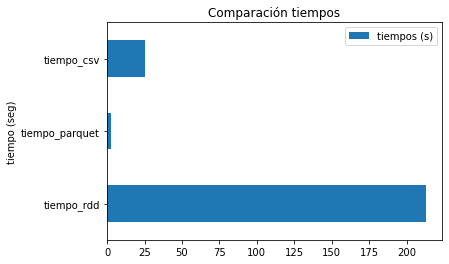

In [25]:
pd.DataFrame([total_rdd, total_parquet, total_csv],
             index=['tiempo_rdd', 'tiempo_parquet', 'tiempo_csv'], columns=['tiempos (s)']).plot(kind='barh',
                                                                                                 title='Comparación tiempos',
                                                                                                ylabel='tiempo (seg)')